## US Consumer Price Index (CPI) and Employment Statistics Analysis for Financial Activities Job categories

### Objective
This notebook has been design to replicate my work done in 2018 to analyze employment levels and inflations for each metro area to figure out how each compares in terms of economic affordability.

### Data source
US Bureau of Labor Statistics
* CPI-W
* State & Metro Employment

### Classifications
Time of interest (Target data are to be normalized against base line)
* Baseline: 2010
* Target: 2019

Geographic areas
* Primary: Areas from State & Metro data are used (e.g., Charlotte-Concord-Gastonia)
* Data interpolation: For metro-areas without having explicit data (e.g., Hourly Wages), state-wide or Census division (e.g., SouthEast)

Employment
* Industry: Only *financial activities* (Supersector code **55**) is selected
* Key figures: Average Hourly Wages, Employment

CPI (Selected categories are to be aggregated to form different scenarios)
* Components
    * Housing: Rent, Housing Operations
    * Food: Eat-in, Eat-out
    * Energy: Household
    * Medical Care
    * Recreation
    * Transportation

In [1]:
# Load libraries
library(dplyr)
library(readr)
library(ggplot2)
library(sf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



In [2]:
# Read employment data
employments <- readr::read_tsv('data/Employment Statistics/sm.data.71.FinancialActivities.Current.txt')

employments <- employments %>%
    subset(select=-c(footnote_codes))

head(employments)

Parsed with column specification:
cols(
  series_id = col_character(),
  year = col_double(),
  period = col_character(),
  value = col_double(),
  footnote_codes = col_character()
)



series_id,year,period,value
<chr>,<dbl>,<chr>,<dbl>
SMS01000005500000001,2007,M01,100.1
SMS01000005500000001,2007,M02,99.9
SMS01000005500000001,2007,M03,100.1
SMS01000005500000001,2007,M04,99.5
SMS01000005500000001,2007,M05,99.7
SMS01000005500000001,2007,M06,99.8


In [3]:
# Read merge info
state <- read_tsv('data/Employment Statistics/sm.state.txt')
head(state)
area <- read_tsv('data/Employment Statistics/sm.area.txt')
head(area)
period <- read_tsv('data/Employment Statistics/sm.period.txt')
head(period)
industry <- read_tsv('data/Employment Statistics/sm.industry.txt') %>%
    dplyr::select(industry_code,industry_name)
head(industry)
data_type <- read_tsv('data/Employment Statistics/sm.data_type.txt')
head(data_type)
area_map <- read_tsv('data/area_map.txt') %>%
    dplyr::mutate(CPI_code = dplyr::if_else(substr(CPI_code,1,1) %in% c('A','S'),paste0('S',substr(CPI_code,2,2),'00'),CPI_code))
head(area_map)

Parsed with column specification:
cols(
  state_code = col_character(),
  state_abbr = col_character(),
  state_name = col_character()
)



state_code,state_abbr,state_name
<chr>,<chr>,<chr>
00,AS,All States
01,AL,Alabama
02,AK,Alaska
04,AZ,Arizona
05,AR,Arkansas
06,CA,California


Parsed with column specification:
cols(
  area_code = col_character(),
  area_name = col_character()
)



area_code,area_name
<chr>,<chr>
00000,Statewide
10180,"Abilene, TX"
10380,"Aguadilla-Isabela, PR"
10420,"Akron, OH"
10500,"Albany, GA"
10540,"Albany, OR"


Parsed with column specification:
cols(
  period = col_character(),
  mm = col_character(),
  month = col_character()
)



period,mm,month
<chr>,<chr>,<chr>
M01,JAN,January
M02,FEB,February
M03,MAR,March
M04,APR,April
M05,MAY,May
M06,JUN,June


Parsed with column specification:
cols(
  industry_code = col_character(),
  industry_name = col_character()
)



industry_code,industry_name
<chr>,<chr>
00000000,Total Nonfarm
05000000,Total Private
06000000,Goods Producing
07000000,Service-Providing
08000000,Private Service Providing
10000000,Mining and Logging


Parsed with column specification:
cols(
  data_type_code = col_character(),
  data_type_text = col_character()
)



data_type_code,data_type_text
<chr>,<chr>
01,"All Employees, In Thousands"
02,Average Weekly Hours of All Employees
03,"Average Hourly Earnings of All Employees, In Dollars"
06,"Production or Nonsupervisory Employees, In Thousands"
07,Average Weekly Hours of Production Employees
08,"Average Hourly Earnings of Production Employees, In Dollars"


Parsed with column specification:
cols(
  SM_code = col_character(),
  CPI_code = col_character()
)



SM_code,CPI_code
<chr>,<chr>
00000,NA
10180,N300
10380,PR
10420,S200
10500,N300
10540,N400


In [4]:
# Tidy up employment data
employments <- tidyr::separate(employments,'series_id',c('category','seasonal','state','area','industry','type'),sep=c(2,3,5,10,18)) %>%
    dplyr::rename("employment"="value") %>%
    dplyr::filter(industry == '55000000' & type %in% c('01','03') & year >= 2010 & period == 'M13' & seasonal != 'S') %>%
    subset(select=-c(seasonal))

head(employments)

category,state,area,industry,type,year,period,employment
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
SM,01,00000,55000000,01,2010,M13,92.0
SM,01,00000,55000000,01,2011,M13,92.4
SM,01,00000,55000000,01,2012,M13,92.6
SM,01,00000,55000000,01,2013,M13,94.2
SM,01,00000,55000000,01,2014,M13,94.8
SM,01,00000,55000000,01,2015,M13,95.4


In [5]:
# Merge dataset
employments <- employments %>%
    dplyr::inner_join(state,by=c('state'='state_code')) %>%
    dplyr::inner_join(area,by=c('area'='area_code')) %>%
    dplyr::inner_join(industry,by=c('industry'='industry_code')) %>%
    dplyr::inner_join(data_type,by=c('type'='data_type_code')) %>%
#     dplyr::inner_join(period,by=c('period')) %>%
    subset(select=-c(state,state_name,industry,period)) %>%
    dplyr::mutate(#mm=stringr::str_to_title(mm),
                  data_type_text=stringr::str_to_title(data_type_text)
                 ) %>%
    dplyr::rename('state'='state_abbr',
                  'area_code'='area',
                  'industry'='industry_name',
                  'data_type'='data_type_text'
#                   ,'month'='mm'
                 )

head(employments)

category,area_code,type,year,employment,state,area_name,industry,data_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
SM,00000,01,2010,92.0,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2011,92.4,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2012,92.6,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2013,94.2,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2014,94.8,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2015,95.4,AL,Statewide,Financial Activities,"All Employees, In Thousands"


In [6]:
# # Aggregate data by year
# employments <- employments %>%
#     dplyr::group_by(category,type,year,state,area,industry,data_type) %>%
#     dplyr::summarize(employment=mean(employment,na.rm=TRUE)) %>%
#     dplyr::ungroup() %>%
#     dplyr::group_by(category,year,state,area,industry) %>%
#     dplyr::mutate(n=dplyr::n()) %>%
#     dplyr::ungroup()

# head(employments)

In [7]:
state_cat <- list('AL'='N300','LA'='N300','AR'='N300','DE'='N300','DC'='N300','FL'='N300','GA'='N300','KY'='N300','LA'='N300','MD'='N300','MS'='N300','NC'='N300','OK'='N300','SC'='N300','TN'='N300','TX'='N300','VA'='N300','WV'='N300',
                 'AZ'='N400','CA'='N400','CO'='N400','ID'='N400','MT'='N400','NV'='N400','OR'='N400','UT'='N400','WA'='N400','WY'='N400','NM'='N400',
                 'CT'='N100','ME'='N100','MA'='N100','NH'='N100','NJ'='N100','NY'='N100','PA'='N100','RI'='N100','VT'='N100',
                 'IL'='N200','IN'='N200','IA'='N200','KS'='N200','MI'='N200','MN'='N200','MO'='N200','NE'='N200','ND'='N200','OH'='N200','SD'='N200','WI'='N200')

employments <- employments %>%
    dplyr::inner_join(area_map,by=c('area_code'='SM_code'),keep=TRUE) %>%
    dplyr::mutate(CPI_code=ifelse(is.na(CPI_code),state_cat[state],CPI_code)) %>%
    dplyr::mutate(CPI_code=as.character(CPI_code)) %>%
    subset(select=-c(area_code)) %>% 
    dplyr::rename('emp_area'='area_name')
head(employments)

category,type,year,employment,state,emp_area,industry,data_type,CPI_code
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
SM,01,2010,92.0,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2011,92.4,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2012,92.6,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2013,94.2,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2014,94.8,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2015,95.4,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300


In [8]:
num_emps <- employments %>%
    dplyr::filter(type == '01') %>%
    dplyr::rename('num_emp'='employment') %>%
    subset(select=-c(type,data_type))

employments <- employments %>%
    dplyr::filter(type == '03') %>%
    dplyr::rename('wage'='employment') %>%
    subset(select=-c(type,data_type))

employments <- num_emps %>%
    dplyr::left_join(employments,by=c('category','year','state','emp_area','CPI_code','industry')) %>%
    dplyr::group_by(category,year,state,industry) %>%
    dplyr::mutate(wage=dplyr::if_else(is.na(wage),0,wage),
                 wage=sum(wage)) %>%
    dplyr::ungroup()

head(employments)

category,year,num_emp,state,emp_area,industry,CPI_code,wage
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
SM,2010,92.0,AL,Statewide,Financial Activities,N300,20.77
SM,2011,92.4,AL,Statewide,Financial Activities,N300,20.97
SM,2012,92.6,AL,Statewide,Financial Activities,N300,21.12
SM,2013,94.2,AL,Statewide,Financial Activities,N300,21.38
SM,2014,94.8,AL,Statewide,Financial Activities,N300,21.80
SM,2015,95.4,AL,Statewide,Financial Activities,N300,22.80


In [9]:
# Read CPI data
inflations <- readr::read_tsv('data/CPI-W/cw.data.0.Current.txt')

inflations <- inflations %>%
    subset(select=-c(footnote_codes))

head(inflations)

Parsed with column specification:
cols(
  series_id = col_character(),
  year = col_double(),
  period = col_character(),
  value = col_double(),
  footnote_codes = col_logical()
)



series_id,year,period,value
<chr>,<dbl>,<chr>,<dbl>
CWSR0000SA0,1997,M01,156.6
CWSR0000SA0,1997,M02,156.9
CWSR0000SA0,1997,M03,156.9
CWSR0000SA0,1997,M04,157.0
CWSR0000SA0,1997,M05,157.0
CWSR0000SA0,1997,M06,157.3


In [10]:
# Read merge info
area <- read_tsv('data/CPI-W/cw.area.txt') %>%
    dplyr::select(area_code,area_name)
head(area)
period <- read_tsv('data/CPI-W/cw.period.txt')
head(period)
item <- read_tsv('data/CPI-W/cw.item.txt') %>%
    dplyr::select(item_code,item_name)
head(item)

Parsed with column specification:
cols(
  area_code = col_character(),
  area_name = col_character(),
  display_level = col_double(),
  selectable = col_logical(),
  sort_sequence = col_double()
)



area_code,area_name
<chr>,<chr>
0000,U.S. city average
0100,Northeast
0110,New England
0120,Middle Atlantic
0200,Midwest
0230,East North Central


Parsed with column specification:
cols(
  period = col_character(),
  period_abbr = col_character(),
  period_name = col_character()
)



period,period_abbr,period_name
<chr>,<chr>,<chr>
M01,JAN,January
M02,FEB,February
M03,MAR,March
M04,APR,April
M05,MAY,May
M06,JUN,June


Parsed with column specification:
cols(
  item_code = col_character(),
  item_name = col_character(),
  display_level = col_double(),
  selectable = col_logical(),
  sort_sequence = col_double()
)



item_code,item_name
<chr>,<chr>
AA0,All items - old base
AA0R,Purchasing power of the consumer dollar - old base
SA0,All items
SA0E,Energy
SA0L1,All items less food
SA0L1E,All items less food and energy


In [11]:
# Tidy up CPI data
inflations <- tidyr::separate(inflations,'series_id',c('category','seasonal','periodicity','area','item'),sep=c(2,3,4,8)) %>%
    dplyr::rename("inflation"="value") %>%
    dplyr::filter(item %in% c('SA0','SA0L1E','SA0R','SAF1','SAF11','SEFV','SAH','SEHA','SAH21','SAH3','SAM','SAR','SAT','SETB') & year >= 2010 & period == 'M13' & seasonal != 'S' & periodicity == 'R') %>%
    subset(select=-c(seasonal,periodicity))

head(inflations)

category,area,item,year,period,inflation
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
CW,0000,SA0,2010,M13,213.967
CW,0000,SA0,2011,M13,221.575
CW,0000,SA0,2012,M13,226.229
CW,0000,SA0,2013,M13,229.324
CW,0000,SA0,2014,M13,232.771
CW,0000,SA0,2015,M13,231.810


In [12]:
# Merge dataset
inflations <- inflations %>%
#     dplyr::inner_join(area,by=c('area'='area_code')) %>%
    dplyr::inner_join(item,by=c('item'='item_code')) %>%
#     dplyr::inner_join(period,by=c('period')) %>%
    subset(select=-c(period)) 
#     dplyr::mutate(period_abbr=stringr::str_to_title(period_abbr)) %>%
#     dplyr::rename('area_code'='area'
#                   ,'month'='period_abbr'
#                  )

head(inflations)

category,area,item,year,inflation,item_name
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
CW,0000,SA0,2010,213.967,All items
CW,0000,SA0,2011,221.575,All items
CW,0000,SA0,2012,226.229,All items
CW,0000,SA0,2013,229.324,All items
CW,0000,SA0,2014,232.771,All items
CW,0000,SA0,2015,231.810,All items


In [13]:
inflations <- inflations %>%
    subset(select=-c(item)) %>%
    tidyr::spread(item_name,inflation)

head(inflations)

category,area,year,All items,All items less food and energy,Food,Food at home,Food away from home,Household energy,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CW,0000,2010,213.967,214.835,218.730,214.638,226.204,187.272,121.555,212.880,389.766,240.094,46.7,109.812,247.725,192.560
CW,0000,2011,221.575,218.461,227.125,225.181,231.504,191.522,121.109,215.810,402.187,303.848,45.1,109.898,251.857,213.296
CW,0000,2012,226.229,223.114,233.059,230.737,238.189,187.269,121.784,219.287,417.750,313.867,44.2,111.127,258.356,218.749
CW,0000,2013,229.324,226.997,236.193,232.835,243.129,191.831,120.784,223.993,428.326,305.116,43.6,111.696,265.516,218.328
CW,0000,2014,232.771,230.799,241.990,238.639,248.996,200.183,118.934,229.896,438.254,293.583,43.0,111.797,273.743,216.387
CW,0000,2015,231.810,234.827,246.462,241.502,256.181,193.272,117.837,234.499,449.602,213.963,43.2,111.845,283.418,197.785


In [14]:
merged <- employments %>%
    dplyr::filter(emp_area != 'Statewide') %>%
    dplyr::inner_join(inflations,by=c('year','CPI_code'='area')) %>%
    dplyr::inner_join(area,by=c('CPI_code'='area_code')) %>%
    dplyr::mutate(area=sub('-.*|,.*|/.*','',emp_area),
                 area=paste0(area,', ',state)) %>%
    subset(select=-c(category.x,category.y,CPI_code,emp_area,area_name))

head(merged)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,Household energy,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation,area
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2010,1.3,AL,Financial Activities,20.77,133.462,124.432,138.575,136.060,142.043,147.947,95.767,132.600,160.462,234.595,NA,111.684,139.826,130.420,"Anniston, AL"
2011,1.3,AL,Financial Activities,20.97,138.828,126.786,143.788,143.049,144.607,152.516,95.568,135.195,165.635,298.971,NA,112.271,143.135,146.149,"Anniston, AL"
2012,1.3,AL,Financial Activities,21.12,141.686,129.411,148.003,147.419,148.599,152.310,96.691,137.660,170.686,304.646,NA,113.824,146.413,148.792,"Anniston, AL"
2013,1.3,AL,Financial Activities,21.38,143.921,131.951,150.628,149.580,151.973,155.523,95.822,140.866,174.497,297.200,NA,115.105,152.063,148.770,"Anniston, AL"
2014,1.4,AL,Financial Activities,21.80,146.067,134.197,154.324,152.961,156.204,162.621,93.293,144.694,177.915,285.559,NA,115.573,157.072,147.884,"Anniston, AL"
2015,1.4,AL,Financial Activities,22.80,144.654,136.254,157.034,154.253,161.117,161.201,92.441,147.316,179.313,199.150,NA,115.197,161.408,133.742,"Anniston, AL"


## Rank calculations
Overall employment rank is calculated with `number of employees` and `average hourly wages` (cardinal)

Basic idea: Difference in values between two adjacent areas (smallest difference) is divided by total difference for all areas (**Max - Min**)

Thus, areas which are closer to higher ranked ones have relatively higher ranks than ordianal ranking system. (When averaging two ranks, those regions can shine)

### Procedures of selections
At first, calculate ranks for `number of employees`, only keeping regions with values larger than mean value. (appr. 70)

Next, based on overall ranks with `number of employees` and `average hourly wages`, only Top 50 regions will be left.

In [15]:
# Baseline summary
merged %>%
    dplyr::group_by(year) %>%
    dplyr::summarize(mean(num_emp),max(num_emp),mean(wage),max(wage)) %>%
    dplyr::ungroup()

`summarise()` ungrouping output (override with `.groups` argument)



year,mean(num_emp),max(num_emp),mean(wage),max(wage)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,22.04866,733.9,24.76361,41.36
2011,22.14299,742.1,24.87618,42.40
2012,22.43582,741.2,25.48961,41.48
2013,22.81373,740.2,26.16060,42.97
2014,23.01821,748.3,26.98499,43.87
2015,23.45552,757.7,28.05490,44.11
2016,23.92627,765.9,29.14173,44.85
2017,24.35254,773.6,30.23334,47.03
2018,24.66209,781.4,31.48400,48.19


In [16]:
# Baseline summary
merged %>%
    dplyr::group_by(year) %>%
    dplyr::summarize_at(vars(names(merged)[8:ncol(merged)-1]),mean) %>%
    dplyr::ungroup()

merged %>%
    dplyr::group_by(year) %>%
    dplyr::summarize_at(vars(names(merged)[8:ncol(merged)-1]),sd) %>%
    dplyr::ungroup()

year,All items less food and energy,Food,Food at home,Food away from home,Household energy,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,134.6305,146.2364,142.9312,151.2450,165.4697,100.66995,140.7501,188.8667,237.2926,NA,109.5914,149.2304,141.5543
2011,137.0451,151.7442,150.1074,154.3381,169.5829,100.81131,143.0275,195.3564,299.6504,NA,109.9091,152.3038,156.2639
2012,139.7516,155.8387,154.0053,158.8135,166.7629,101.82170,145.0662,202.4473,309.0889,NA,111.0739,155.4610,159.9671
2013,141.9056,158.0056,155.3911,162.4625,171.2452,100.86177,148.0073,206.4506,300.6488,NA,111.9268,159.4915,159.3404
2014,144.1168,161.9050,159.2121,166.5485,178.9522,99.42135,151.5447,211.1428,290.1431,NA,112.2451,163.5742,158.0019
2015,146.2137,164.4028,160.4335,171.3296,175.2108,98.73780,153.8910,216.0126,208.9724,NA,112.1237,167.8398,144.2520
2016,148.9781,164.3498,158.0417,175.2221,172.5032,97.81441,156.8695,224.0423,184.4947,NA,112.8926,172.9192,140.6846
2017,151.2518,165.4705,157.5663,178.9961,178.3960,96.67961,161.0524,229.6158,207.4866,NA,114.6987,178.6115,145.6805
2018,154.2451,167.5840,158.2737,183.4378,180.0509,97.05155,165.3812,233.7309,234.8563,NA,114.9855,184.6432,152.6084


year,All items less food and energy,Food,Food at home,Food away from home,Household energy,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,27.12385,24.68669,25.09626,24.32892,17.28360,9.058558,26.27215,66.24074,8.728184,NA,8.785356,37.36891,18.15678
2011,27.44510,25.70952,26.17286,25.27765,17.47598,8.755099,26.46220,67.77655,14.552668,NA,8.500865,37.63613,20.05939
2012,28.14273,26.19360,26.50383,26.00236,15.73229,8.266823,27.09733,71.13355,13.812949,NA,9.471285,39.11466,20.90072
2013,28.78111,26.44081,26.70696,26.32707,17.52775,8.401857,28.01095,73.65434,15.127692,NA,9.875603,40.59527,20.85797
2014,29.38521,27.10610,27.41767,26.91324,17.77376,8.394285,29.11596,75.72453,14.159823,NA,9.816586,42.45390,20.37002
2015,30.16538,27.94960,28.23052,27.72025,17.69373,8.257833,30.39312,78.62715,9.876558,NA,9.979919,44.85672,19.08378
2016,31.19531,28.31135,28.01973,28.88354,19.62471,8.342171,32.14042,82.54440,8.938869,NA,9.746884,47.44949,18.18865
2017,32.15161,28.73259,28.05882,29.88098,19.09532,8.277656,33.92706,84.74702,9.480235,NA,9.996920,50.23961,18.98301
2018,33.25300,29.33221,28.18399,31.18497,21.57008,8.115560,35.67859,86.39357,11.469621,NA,9.949882,52.90045,20.72712


In [17]:
# Calculate Wages and CPI increases (Percentage)
merged <- merged %>%
    dplyr::group_by(area) %>%
    dplyr::mutate(wage_inc = wage/first(wage)*100) %>%
    dplyr::mutate_at(vars(names(merged)[8:ncol(merged)-2]),funs(./first(.)*100)) %>%
    dplyr::ungroup()

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [18]:
head(merged)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,⋯,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation,area,wage_inc
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2010,1.3,AL,Financial Activities,20.77,100.0000,100.0000,100.0000,100.0000,100.0000,⋯,100.00000,100.0000,100.0000,100.00000,NA,100.0000,100.0000,130.420,"Anniston, AL",100.0000
2011,1.3,AL,Financial Activities,20.97,104.0206,101.8918,103.7619,105.1367,101.8051,⋯,99.79220,101.9570,103.2238,127.44134,NA,100.5256,102.3665,146.149,"Anniston, AL",100.9629
2012,1.3,AL,Financial Activities,21.12,106.1621,104.0014,106.8035,108.3485,104.6155,⋯,100.96484,103.8160,106.3716,129.86040,NA,101.9161,104.7109,148.792,"Anniston, AL",101.6851
2013,1.3,AL,Financial Activities,21.38,107.8367,106.0427,108.6978,109.9368,106.9908,⋯,100.05743,106.2338,108.7466,126.68642,NA,103.0631,108.7516,148.770,"Anniston, AL",102.9369
2014,1.4,AL,Financial Activities,21.80,109.4446,107.8477,111.3650,112.4217,109.9695,⋯,97.41665,109.1207,110.8767,121.72425,NA,103.4821,112.3339,147.884,"Anniston, AL",104.9591
2015,1.4,AL,Financial Activities,22.80,108.3859,109.5008,113.3206,113.3713,113.4283,⋯,96.52699,111.0980,111.7480,84.89098,NA,103.1455,115.4349,133.742,"Anniston, AL",109.7737


In [19]:
merged <- merged %>%
    dplyr::group_by(year) %>%
    dplyr::filter(num_emp >= mean(num_emp,na.rm=TRUE)) %>%
    dplyr::mutate(emp_order = length(num_emp)-(num_emp-min(num_emp))/((max(num_emp)-min(num_emp))/(length(num_emp)-1)),
                  wage_order = length(wage)-(wage-min(wage))/((max(wage)-min(wage))/(length(wage)-1)),
                  order = dense_rank(emp_order+wage_order)
    ) %>%
    arrange(order) %>%
    dplyr::ungroup() %>%
    dplyr::filter(order<=25) %>%
    subset(select=-c(emp_order,wage_order))

In [20]:
head(merged)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,⋯,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation,area,wage_inc,order
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
2010,733.9,NY,Financial Activities,35.10,100.0000,100.0000,100.0000,100.0000,100.0000,⋯,100.0000,100.0000,100.00000,NA,100.0000,100.0000,196.655,"New York, NY",100.00000,1
2011,742.1,NY,Financial Activities,34.89,103.2557,101.8547,103.6233,104.1597,102.8662,⋯,101.4456,102.9863,127.63635,NA,100.1440,101.9022,217.691,"New York, NY",99.40171,1
2012,741.2,NY,Financial Activities,36.89,105.3739,104.0577,106.3757,106.9943,105.5359,⋯,102.9068,106.9942,132.63031,NA,102.2405,104.3875,223.488,"New York, NY",105.09972,1
2013,740.2,NY,Financial Activities,39.43,106.9185,105.9992,107.5318,108.0126,106.9034,⋯,104.8619,110.4774,128.38682,NA,103.0160,107.2832,225.163,"New York, NY",112.33618,1
2014,748.3,NY,Financial Activities,41.62,108.2606,107.5215,109.4279,109.8613,108.7870,⋯,107.3066,112.5978,123.79713,NA,102.3734,110.2597,223.972,"New York, NY",118.57550,1
2015,757.7,NY,Financial Activities,43.15,108.1285,109.4801,111.5891,111.8862,111.1911,⋯,108.5868,115.9616,87.82268,NA,102.9563,113.4336,206.341,"New York, NY",122.93447,1


In [21]:
# Plot of employment 
target_col <- c('num_emp','wage')
target_text <- c('Number of workers','Avg Hourly wages')
emp_maps <- list()

for (iter in 1:2) {
    # Set levels for descending chart        
    lvl <- merged %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(!!sym(target_col[iter])) %>%
        dplyr::distinct(area)

    lvl <- as.vector(lvl$area)
    
    emp_maps[[iter]] <- merged %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(target_col[iter]) %>%
        dplyr::mutate(area=factor(area,levels=lvl)) %>%
        ggplot2::ggplot(ggplot2::aes(y=area,x=!!sym(target_col[iter]))) +
        ggplot2::geom_bar(stat='identity',fill='#fdae6b') +
        ggplot2::labs(x=target_text[iter],y='Metro region',
                      caption="Source: US Bureau of Labor Statistics, 2020",
                      title=paste('US Employment status as of',max(merged$year)),
                      subtitle=target_text[iter]) +
        ggplot2::theme_grey(base_size=8)
    
    if (iter == 1) {
        emp_maps[[iter]] <- emp_maps[[iter]] + 
            ggplot2::scale_x_continuous(expand=c(0,0),label=scales::label_number(suffix='K'))
        }
    else {
        emp_maps[[iter]] <- emp_maps[[iter]] + 
            ggplot2::scale_x_continuous(expand=c(0,0),label=scales::label_number(prefix='$'))
    }
        

    emp_maps[[iter]]

}

g <- do.call(gridExtra::arrangeGrob,emp_maps)

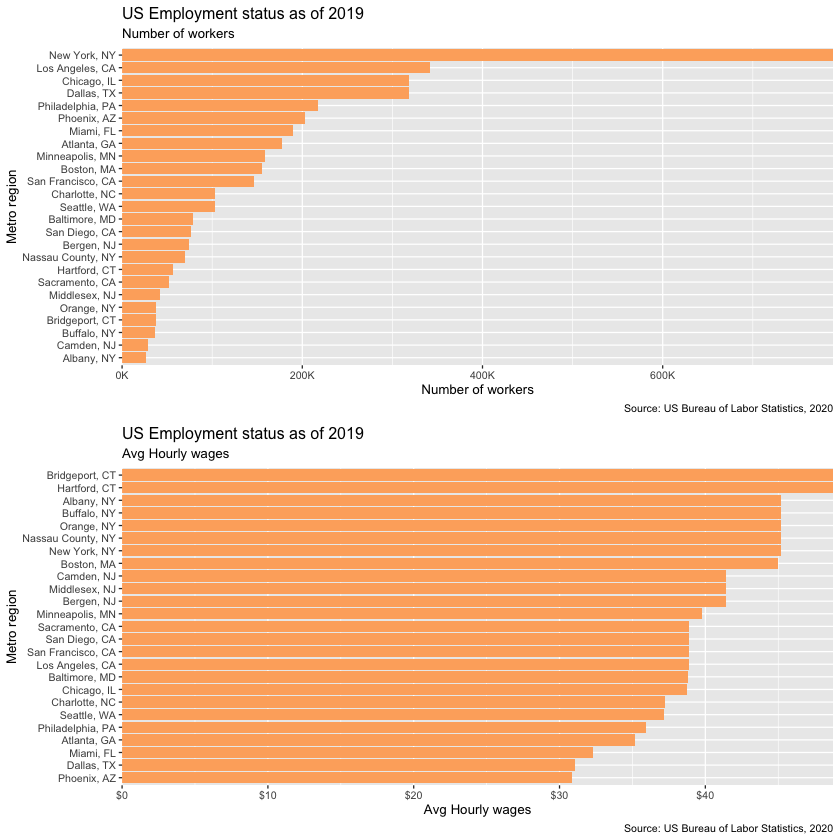

In [22]:
grid::grid.draw(g)
# ggplot2::ggsave(g,filename='emp.png',dpi=200)

# Construction of CPI scenarios

As we have examined on employment status, now is the time to construct scenarios for most spendable items.
From my original work, I have determined to follow these three cases.

<table>
    <thead>
        <tr>
            <th colspan=2 style="text-align:center">Items / Scenarios</th>
            <th>Scenario 1</th>
            <th>Scenario 2</th>
            <th>Scenario 3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2><strong>Housing</strong></td>
            <td>Rent of primary residence</td>
            <td>45%</td>
            <td>15%</td>
            <td>15%</td>
        </tr>
        <tr>
            <td>Household furnishings and operations</td>
            <td>10%</td>
            <td>10%</td>
            <td>10%</td>
        </tr>
        <tr>
            <td rowspan=2><strong>Food</strong></td>
            <td>Food at home</td>
            <td>15%</td>
            <td>10%</td>
            <td>20%</td>
        </tr>
        <tr>
            <td>Food away from home</td>
            <td>5%</td>
            <td>10%</td>
            <td>10%</td>
        </tr>
        <tr>
            <td><strong>Energy</strong></td>
            <td>Household energy</td>
            <td>10%</td>
            <td>25%</td>
            <td>5%</td>
        </tr>
        <tr>
            <td><strong>Medical care</strong></td>
            <td><em>(Overall)</em></td>
            <td>0%</td>
            <td>0%</td>
            <td>30%</td>
        </tr>
        <tr>
            <td><strong>Recreation</strong></td>
            <td><em>(Overall)</em></td>
            <td>0%</td>
            <td>20%</td>
            <td>0%</td>
        </tr>
        <tr>
            <td><strong>Transportation</strong></td>
            <td><em>(Overall)</em></td>>
            <td>15%</td>
            <td>10%</td>
            <td>10%</td>
        </tr>
        <tr>
            <td colspan=2 style="text-align:center"><strong>Total</strong></td>
            <td>100%</td>
            <td>100%</td>
            <td>100%</td>
        </tr>
    </tbody>
</table>

In [23]:
weights <- list(list('Rent of primary residence'=0.45,'Household furnishings and operations'=0.1,'Food at home'=0.15,'Food away from home'=0.05,'Household energy'=0.1,'Transportation'=0.15),
                list('Rent of primary residence'=0.15,'Household furnishings and operations'=0.1,'Food at home'=0.1,'Food away from home'=0.1,'Household energy'=0.25,'Recreation'=0.2,'Transportation'=0.1),
                list('Rent of primary residence'=0.15,'Household furnishings and operations'=0.1,'Food at home'=0.2,'Food away from home'=0.1,'Household energy'=0.05,'Medical care'=0.3,'Transportation'=0.1)
)
weights

[[1]]
[[1]]$`Rent of primary residence`
[1] 0.45

[[1]]$`Household furnishings and operations`
[1] 0.1

[[1]]$`Food at home`
[1] 0.15

[[1]]$`Food away from home`
[1] 0.05

[[1]]$`Household energy`
[1] 0.1

[[1]]$Transportation
[1] 0.15


[[2]]
[[2]]$`Rent of primary residence`
[1] 0.15

[[2]]$`Household furnishings and operations`
[1] 0.1

[[2]]$`Food at home`
[1] 0.1

[[2]]$`Food away from home`
[1] 0.1

[[2]]$`Household energy`
[1] 0.25

[[2]]$Recreation
[1] 0.2

[[2]]$Transportation
[1] 0.1


[[3]]
[[3]]$`Rent of primary residence`
[1] 0.15

[[3]]$`Household furnishings and operations`
[1] 0.1

[[3]]$`Food at home`
[1] 0.2

[[3]]$`Food away from home`
[1] 0.1

[[3]]$`Household energy`
[1] 0.05

[[3]]$`Medical care`
[1] 0.3

[[3]]$Transportation
[1] 0.1

In [24]:
head(merged)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,⋯,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Rent of primary residence,Transportation,area,wage_inc,order
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
2010,733.9,NY,Financial Activities,35.10,100.0000,100.0000,100.0000,100.0000,100.0000,⋯,100.0000,100.0000,100.00000,NA,100.0000,100.0000,196.655,"New York, NY",100.00000,1
2011,742.1,NY,Financial Activities,34.89,103.2557,101.8547,103.6233,104.1597,102.8662,⋯,101.4456,102.9863,127.63635,NA,100.1440,101.9022,217.691,"New York, NY",99.40171,1
2012,741.2,NY,Financial Activities,36.89,105.3739,104.0577,106.3757,106.9943,105.5359,⋯,102.9068,106.9942,132.63031,NA,102.2405,104.3875,223.488,"New York, NY",105.09972,1
2013,740.2,NY,Financial Activities,39.43,106.9185,105.9992,107.5318,108.0126,106.9034,⋯,104.8619,110.4774,128.38682,NA,103.0160,107.2832,225.163,"New York, NY",112.33618,1
2014,748.3,NY,Financial Activities,41.62,108.2606,107.5215,109.4279,109.8613,108.7870,⋯,107.3066,112.5978,123.79713,NA,102.3734,110.2597,223.972,"New York, NY",118.57550,1
2015,757.7,NY,Financial Activities,43.15,108.1285,109.4801,111.5891,111.8862,111.1911,⋯,108.5868,115.9616,87.82268,NA,102.9563,113.4336,206.341,"New York, NY",122.93447,1


In [30]:
# Calculate CPI with selected items (eCPI_x) and wage increases against CPI (eWage_x)
cpi <- merged %>%
    dplyr::filter(year==2019)

for (iter in 1:3) {
        target_cols = as.vector(names(weights[[iter]]))
        cpi <- cpi %>%
            dplyr::mutate_if(names(.) %in% names(weights[[iter]]),funs(!!as.character(iter) := .*weights[[iter]][[deparse(substitute(.))]])) %>%
            dplyr::mutate(!!paste0('eCPI_',iter) := select(., ends_with(paste0('_',as.character(iter)))) %>% rowSums(),
                         !!paste0('eWage_',iter) := wage_inc/!!sym(paste0('eCPI_',iter))*100)

}

In [31]:
head(cpi)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,⋯,eWage_2,Food at home_3,Food away from home_3,Household energy_3,Household furnishings and operations_3,Medical care_3,Rent of primary residence_3,Transportation_3,eCPI_3,eWage_3
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019,789.4,NY,Financial Activities,45.20,115.5550,117.1386,117.3070,113.4964,124.0429,⋯,107.1160,22.69928,12.40429,5.029232,9.299264,39.93789,18.94953,21.7039,130.0234,99.03982
2019,341.3,CA,Financial Activities,38.86,123.1858,124.4941,120.3622,112.4795,132.1728,⋯,100.3128,22.49590,13.21728,5.843318,9.919839,39.18149,21.60579,22.1002,134.3638,95.16775
2019,318.3,IL,Financial Activities,38.71,113.9396,115.5616,117.0628,111.3456,126.7854,⋯,116.4206,22.26913,12.67854,5.084945,9.238399,38.40635,18.97157,19.8829,126.5318,108.40926
2019,155.6,MA,Financial Activities,44.95,115.5550,117.1386,117.3070,113.4964,124.0429,⋯,116.8430,22.69928,12.40429,5.029232,9.299264,39.93789,18.94953,21.7039,130.0234,108.03345
2019,56.4,CT,Financial Activities,48.78,112.2619,113.8858,116.2695,110.6575,125.6963,⋯,104.3998,22.13150,12.56963,5.337043,9.584134,37.11436,18.08208,13.8814,118.7002,99.35963
2019,318.2,TX,Financial Activities,31.07,117.5395,120.8676,116.3500,112.1378,122.9646,⋯,100.7305,22.42756,12.29646,4.978614,9.498263,40.93777,20.44713,21.6307,132.2165,92.04598


In [32]:
# Plot of CPI 
target_col <- c('eCPI_1','eCPI_2','eCPI_3')
target_text <- c('Price Index - Scenario 1','Price Index - Scenario 2','Price Index - Scenario 3')
cpi_maps <- list()

for (iter in 1:3) {
    # Set levels for descending chart        
    lvl <- cpi %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(!!sym(target_col[iter])) %>%
        dplyr::distinct(area)

    lvl <- as.vector(lvl$area)
    
    cpi_maps[[iter]] <- cpi %>%
        dplyr::select(year,area,state,industry,ends_with(paste0('_',as.character(iter)))) %>%
        select(!starts_with('eWage')) %>%
        tidyr::gather(-year,-state,-area,-industry,-!!sym(target_col[iter]),key='Type',value='Value') %>%    
        dplyr::filter(year==2019) %>%
        dplyr::arrange(target_col[iter]) %>%
        dplyr::mutate(area=factor(area,levels=lvl)) %>%
        ggplot2::ggplot(ggplot2::aes(y=area,x=Value)) +
        ggplot2::scale_x_continuous(expand=c(0,0)) +
#         ggplot2::geom_bar(stat='identity',fill='#fdae6b') +
        ggplot2::geom_col(ggplot2::aes(fill=`Type`)) +
        ggplot2::scale_fill_brewer(palette='Dark2') +
        ggplot2::labs(x=target_text[iter],y='Metro region',
                      caption="Source: US Bureau of Labor Statistics, 2020",
                      title=paste('US metro areas Price Index as of',max(merged$year)),
                      subtitle=target_text[iter]) +
        ggplot2::theme_grey(base_size=7)
    
}

g <- do.call(gridExtra::arrangeGrob,cpi_maps)

Saving 7 x 7 in image



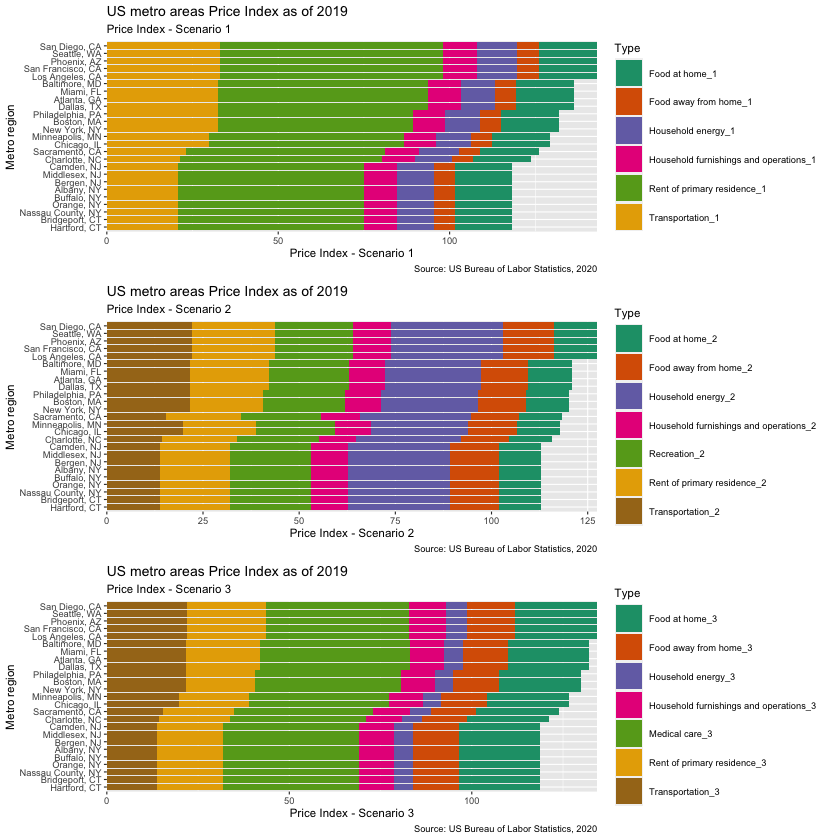

In [33]:
grid::grid.draw(g)
ggplot2::ggsave(g,filename='cpi.png',dpi=200)

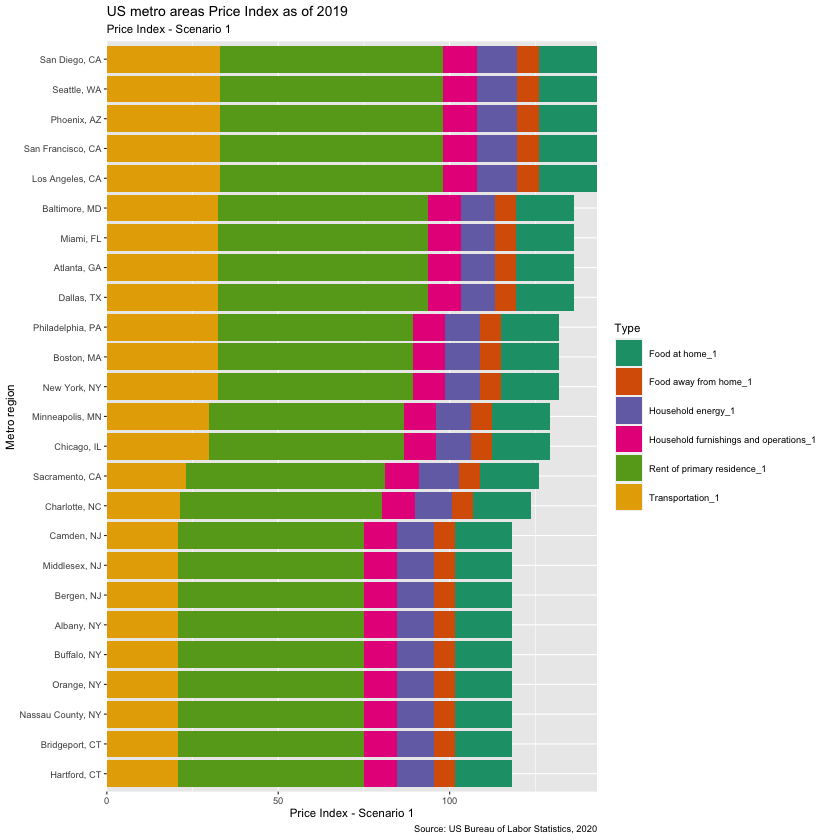

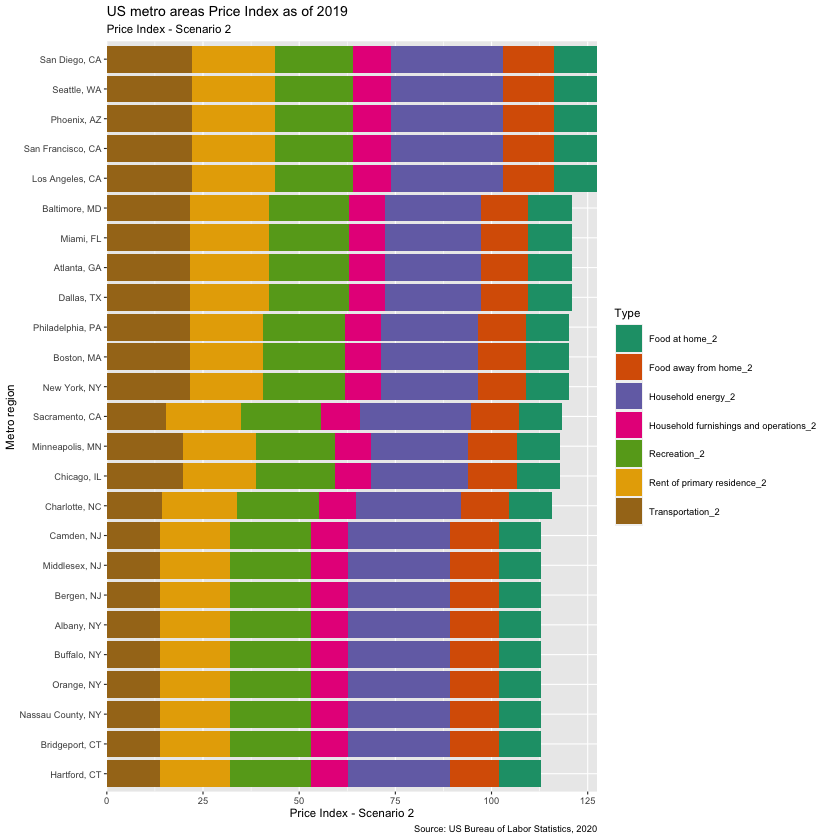

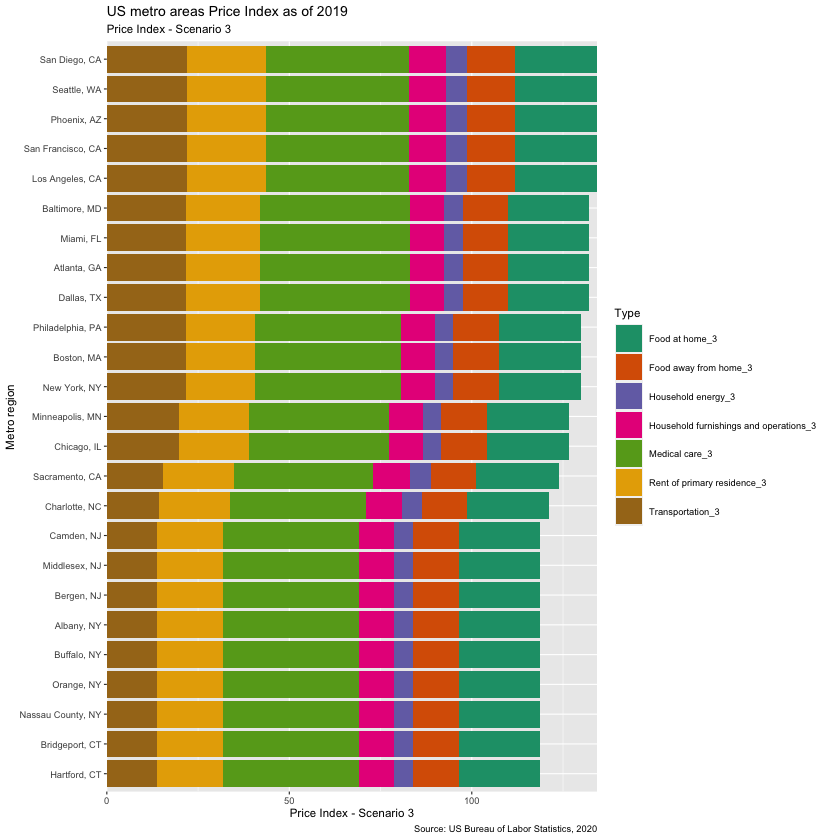

In [34]:
cpi_maps[[1]]
cpi_maps[[2]]
cpi_maps[[3]]

In [35]:
# Plot of Effective Wages 
target_col <- c('eWage_1','eWage_2','eWage_3')
target_text <- c('Effective Wage - Scenario 1','Effective Wage - Scenario 2','Effective Wage - Scenario 3')
ew_maps <- list()

for (iter in 1:3) {
    # Set levels for descending chart        
    lvl <- cpi %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(!!sym(target_col[iter])) %>%
        dplyr::distinct(area)

    lvl <- as.vector(lvl$area)
    
    ew_maps[[iter]] <- cpi %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(target_col[iter]) %>%
        dplyr::mutate(area=factor(area,levels=lvl)) %>%
        ggplot2::ggplot(ggplot2::aes(y=area,x=!!sym(target_col[iter]))) +
        ggplot2::scale_x_continuous(expand=c(0,0)) +
        ggplot2::geom_bar(stat='identity',fill='#fdae6b') +
#         ggplot2::geom_col(ggplot2::aes(fill=`Type`)) +
#         ggplot2::scale_fill_brewer(palette='Dark2') +
        ggplot2::labs(x=target_text[iter],y='Metro region',
                      caption="Source: US Bureau of Labor Statistics, 2020",
                      title=paste('US metro areas affordability as of',max(merged$year)),
                      subtitle=target_text[iter]) +
        ggplot2::theme_grey(base_size=7)
    
}

g <- do.call(gridExtra::arrangeGrob,ew_maps)

Saving 7 x 7 in image



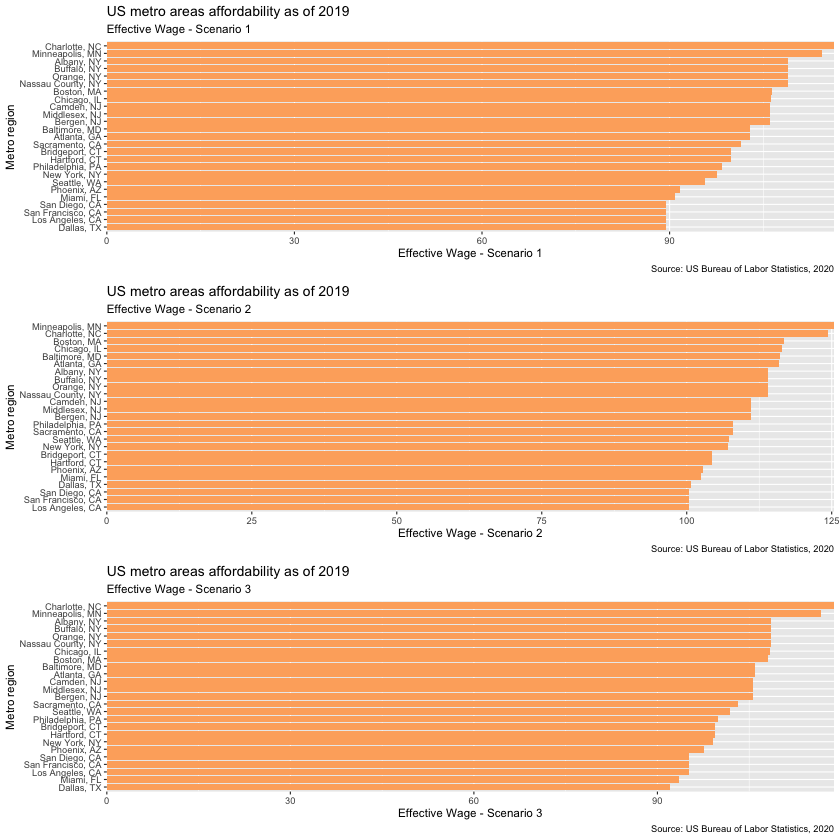

In [36]:
grid::grid.draw(g)
ggplot2::ggsave(g,filename='ewage.png',dpi=200)

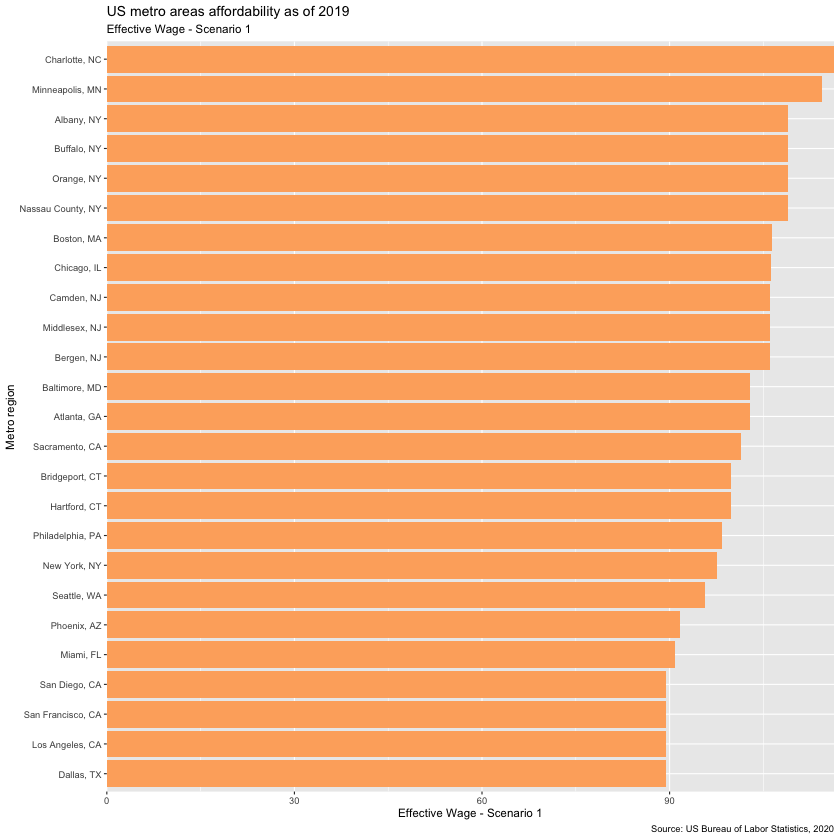

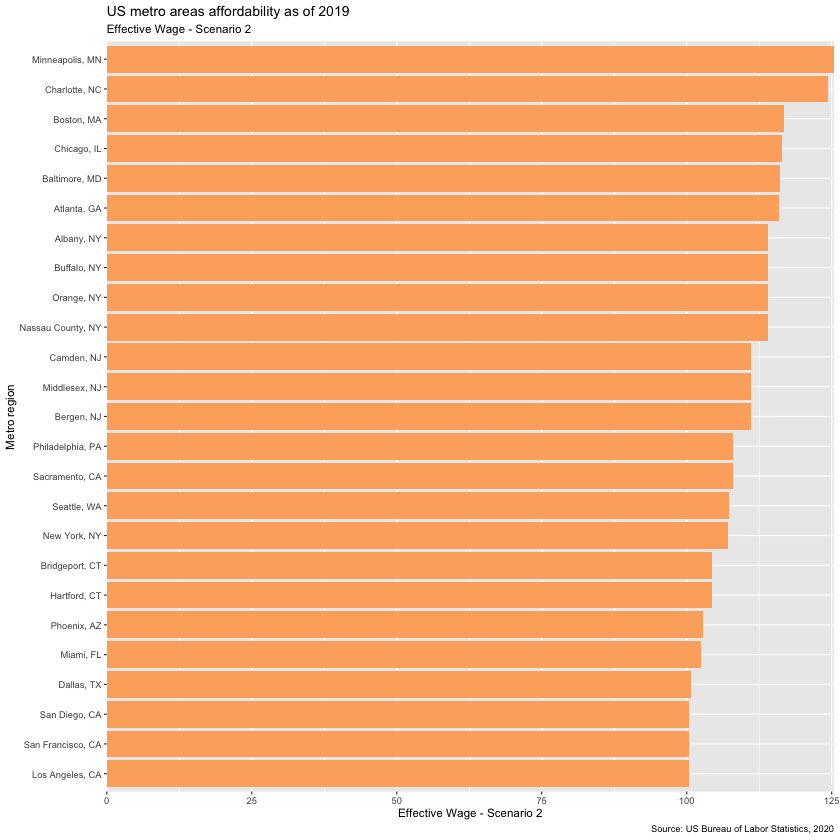

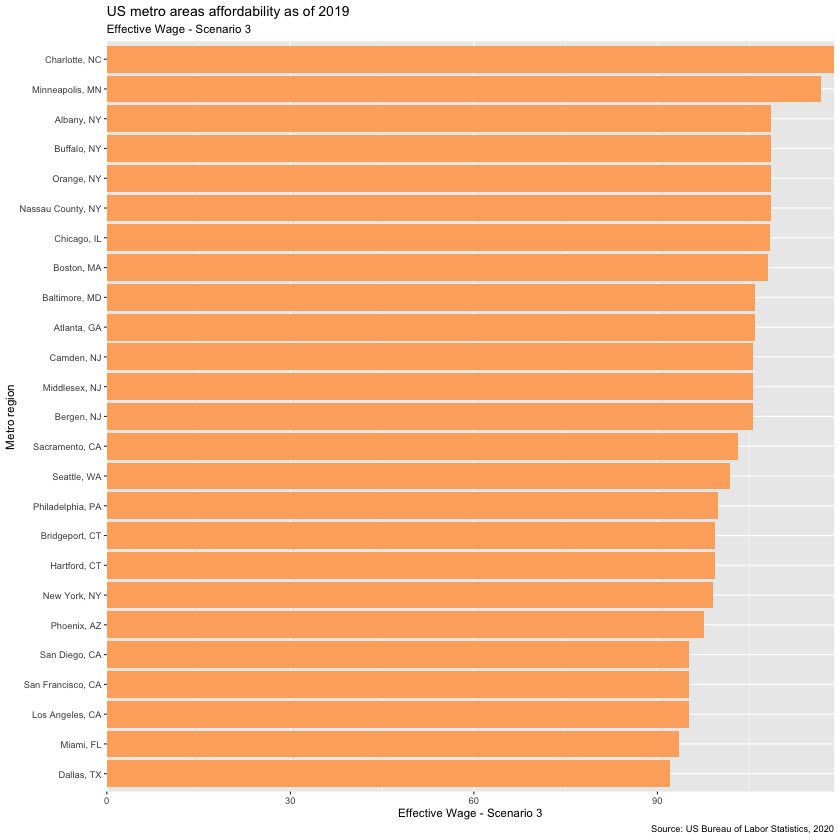

In [37]:
ew_maps[[1]]
ew_maps[[2]]
ew_maps[[3]]

## Conclusion

As can be seen from above, **Charlotte** tops other cities in *scenario 1 and 3*, while sits on second for scenario 2. And, two most favorable cities, namely, **Charlotte and Minneapolis** vie for the top, as they don't show large gaps between them.

This result is somewhat interesting, as in my original work, *Baltimore tops with Minneapolis* being the second. The behavior of these two resemble from what I just drew above.

At that time, Charlotte was on the *5th place*. From the initial investigations, it seems that financiers in the region could boost their salaries for the past year, and therefore, topped the rank.

Also worthwhile to note is that Big names in the financial industry including NYC, Chicago and Boston slide from where they were. This is exactly what I expected to see during my original work, but didn't materialize at the time thanks to huge pay rises. 